In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np
import nltk
from nltk.tokenize.casual import casual_tokenize as tokenizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import operator
import re
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from random import randint

In [3]:
# import Original data
OG_data = pd.read_csv('Vigiglobe2-1.csv')

In [59]:
# import all 13 files 
# some files broken, import manually
all_files = []
l = list(range(1, 13))
for i in l: 
    j = 'IRAhandle_tweets_'+ str(i) + '.csv'
    all_files.append(j)
all_files

frame = pd.DataFrame()
list_ = []
for file in all_files:
    df = pd.read_csv(file)
    list_.append(df)
    print(file)
frame = pd.concat(list_)

IRAhandle_tweets_1.csv
IRAhandle_tweets_2.csv
IRAhandle_tweets_3.csv
IRAhandle_tweets_4.csv
IRAhandle_tweets_6.csv
IRAhandle_tweets_7.csv


/Users/helene/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


IRAhandle_tweets_12.csv
IRAhandle_tweets_13.csv


In [4]:
# import if other import doens't work
f = pd.read_csv('IRAhandle_tweets_1.csv')
s = pd.read_csv('IRAhandle_tweets_2.csv')
t = pd.read_csv('IRAhandle_tweets_3.csv')
fo = pd.read_csv('IRAhandle_tweets_4.csv')
fi = pd.read_excel('IRAhandle_tweets_5_XL.xls')
si = pd.read_csv('IRAhandle_tweets_6.csv')
se = pd.read_csv('IRAhandle_tweets_7.csv')
ei = pd.read_csv('IRAhandle_tweets_8.csv')
ni = pd.read_csv('IRAhandle_tweets_9.csv')
ten = pd.read_excel('IRAhandle_tweets_10_XL.xls')
el = pd.read_csv('IRAhandle_tweets_11.csv')
tw = pd.read_excel('IRAhandle_tweets_12_XL.xlsx')
th = pd.read_csv('IRAhandle_tweets_13.csv')
frame = pd.concat([f, s, t, fo, fi, si, se, ei, ni, ten, el, tw, th])

In [5]:
# creates a set of all account names in the brexit and bot data set
# make everything lower case as bot data is caps only

screen_names = set(list(OG_data['screen_name']))
russia_acc = set(list(frame['author']))
russia_acc_low = [x.lower() for x in russia_acc]
screen_name_low = [str(x).lower() for x in screen_names]
OG_data['screen_name_low'] = OG_data['screen_name'].str.lower() # make name in OG date lowerstring 

In [6]:
# create list of all bots account in brexit data
# it is all lower case. remember when merging
# loops over the brexit account names and adds the ones that are in the bot data to a list
# output is list containing all bot accounts in the brexit data
bot_acc = []
for i in screen_name_low:
    if i in russia_acc_low:
        bot_acc.append(i) # list of bots in data set

In [7]:
# brexit data with binary bot column
bot_df = pd.DataFrame(bot_acc)
bot_df['bot'] = 1 
bot_df.columns = ['screen_name_low', 'bot'] # dataframe with all UK accoutns that are bots
OG_data_bots = OG_data.merge(bot_df, "left", on = 'screen_name_low') # OG data with bot column

In [8]:
# russia data set
frame['screen_name_low'] = frame['author'].str.lower()
# only select russian accounts that are in Brexit data, otherwise later too big to merge
russia_UK_bots = frame.merge(bot_df, "left", on = 'screen_name_low') # russia data with bot column for UK accounts
russia_UK_bots = russia_UK_bots[russia_UK_bots['bot'] == 1] # keep only accounts that are also in brexit data

Problem with merging the russia and brexit tweets: the text is different - can't find common texts

when selecting only the accounts in the russia bot df that are also brexit accounts there are still 923k tweets left in the russia df. But: only 778 of those tweets are also in the brexit data. 

In [11]:
# found two NA values in text from the orgiginal data. should have deleted at the beginning but didnt see therefore deleting now
OG_data_bots = OG_data_bots[OG_data_bots['text'].notnull()]
# counts: number of times tweet appears, ergo number of times tweet gets retweeted or reposted
counts = pd.DataFrame(OG_data_bots.groupby('text').size().reset_index(name='counts'))
# merge counts data frame to OG data frame
OG_data_bots = OG_data_bots.merge(counts, 'left', on = 'text')

# bot: binary column with 1 if it's a bot account and 0 if not
OG_data_bots['bot'].fillna(0, inplace=True)

In [23]:
# identify person who first tweeted
# data sorted by tweet and time, and only person who first posted the tweet is marked as the original tweeter
# or when it has 0 retweets it is an original poster as well 
OG_tweeter = OG_data_bots.sort_values(['text', 'timestamp']).groupby('text').nth(0).reset_index()
OG_tweeter['OG'] = 1
OG_tweeter.loc[OG_tweeter['retweets'] >0, 'OG'] = 0
OG_tweet = OG_tweeter[['text', 'screen_name', 'OG']]

In [26]:
# add the OG poster column to the data
bots = OG_data_bots.merge(OG_tweet, how = 'left', on = ['text', 'screen_name'])
# replace NA with 0 and add that if retweets = 0 then OG = 1 (normally not needed but just to make sure)
bots['OG'].fillna(0, inplace=True)
bots.loc[bots['retweets'] == 0, 'OG'] = 1

In [41]:
# save the new data set 
bots_UK_russia_csv = bots.copy()
bots_UK_russia_csv['text'] = bots_UK_russia_csv['text'].str.replace('\r', ' ')
bots_UK_russia_csv.to_csv('bots_UK_russia.csv', index = False)

# EDA UK

In [42]:
# data set with only bots
only_bots = bots[bots['bot'] == 1]
only_bots['date'], only_bots['time'] = only_bots['timestamp'].str.split('T',1).str
only_bots['date'] = pd.to_datetime(only_bots['date'])

### Number of OG tweets and retweets for bots

In [64]:
# how many are OG tweets
print(' Bot as OG tweeter:', len(only_bots[only_bots['OG'] == 1]), 'Bot as Retweet:', len(only_bots[only_bots['OG'] == 0]))

 Bot as OG tweeter: 441 Bot as Retweet: 317


### Number of tweets, retweets and reposts of bots over timeperiod

In [55]:
# plot the bots
def time_barplot (data, timeperiode):
    # for timeperiode put in "month" or "week"
    if timeperiode == 'day':
        p = ''
    if timeperiode == 'month':
        p = '%m'
    if timeperiode == 'week':
        p = '%U'

    ax = data.groupby(['bot', data['date'].dt.strftime(p)])['date'].count().unstack(0).plot.bar(title="Number of bots per " + timeperiode, figsize=(14,8))
    _ = ax.set_xlabel(timeperiode)
    _ = ax.set_ylabel('bot count')
    mylabels = ['bot', 'bot']
    _ = ax.legend(labels=mylabels)
    plt.show()

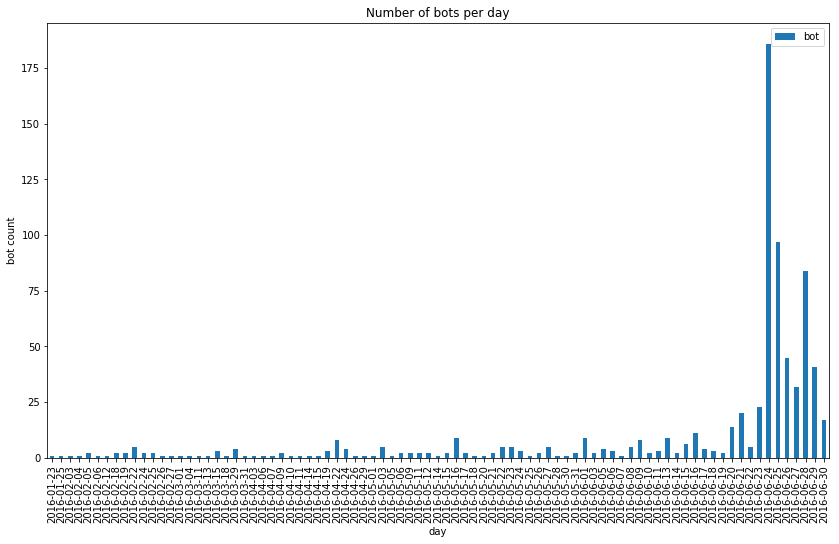

In [68]:
time_barplot(only_bots, 'day')

[Interesing to see that highest bot activity happened after the brexit vote. ]

### Number of bots per timeperiod devided into OG or not retweet

In [148]:
# original poster versus retweeter
def OG_barplot (data, timeperiode):
    # for timeperiode put in "month" or "week"
    if timeperiode == 'day':
        p = ''
    if timeperiode == 'month':
        p = '%m'
    if timeperiode == 'week':
        p = '%U'

    ax = data.groupby(['OG', data['date'].dt.strftime(p)])['date'].count().unstack(0).plot.bar(title="Number of bots per " + timeperiode, figsize=(14,8))
    _ = ax.set_xlabel(timeperiode)
    _ = ax.set_ylabel('bot count')
    mylabels = ['retweet', 'OG tweeter']
    _ = ax.legend(labels=mylabels)
    plt.show()

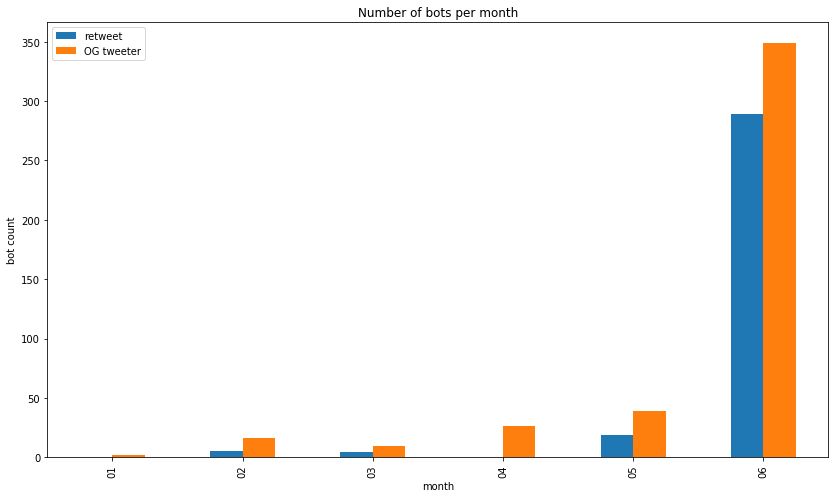

In [150]:
OG_barplot(only_bots, 'month')

### Retweets and reposts across bot and not bot accounts

[When saying that a bot is involved in the communication I mean that a bot has either started a tweet or retweeted a tweet]

In [67]:
# average number of retweets/reposts 
print('average number of retweets/reposts when bot is OG tweeter:',
     round(np.mean(only_bots['counts'][only_bots['OG'] == 1]), 2))
print('average number of retweets/reposts when bot is not OG tweeter, but bot involved in communication:',
     round(np.mean(only_bots['counts'][only_bots['OG'] == 0]), 2))
print('average number of retweets/reposts across whole data set',
     round(np.mean(bots['counts']), 2))

average number of retweets/reposts when bot is OG tweeter: 9.6
average number of retweets/reposts when bot is not OG tweeter, but bot involved in communication: 305.38
average number of retweets/reposts across whole data set 889.55


### Bot account total activity

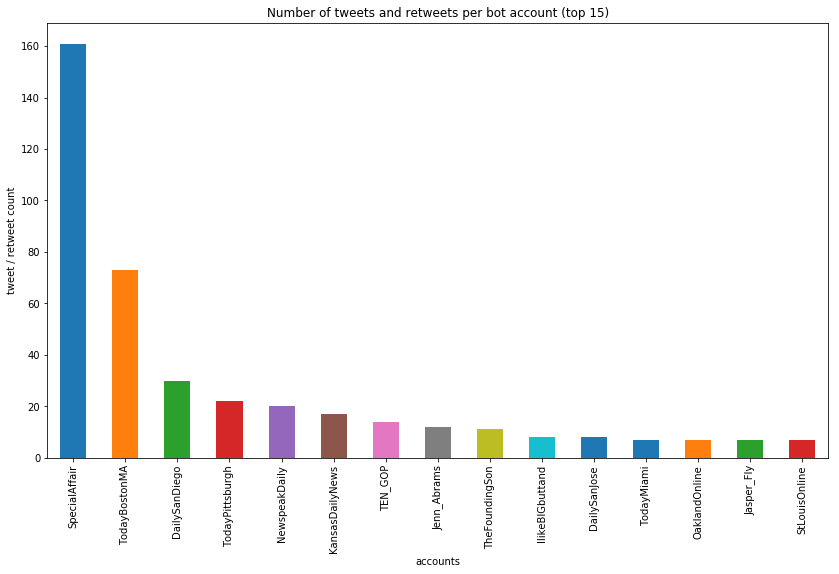

In [86]:
# number of tweets and retweets per bot account
ax = only_bots['screen_name'].value_counts().sort_values(ascending = False)[:15].plot.bar(title="Number of tweets and retweets per bot account (top 15)", figsize=(14,8))
_ = ax.set_xlabel('account name')
_ = ax.set_ylabel('tweet / retweet count')
plt.show()

### Original tweet vs. retweet per bot accounts

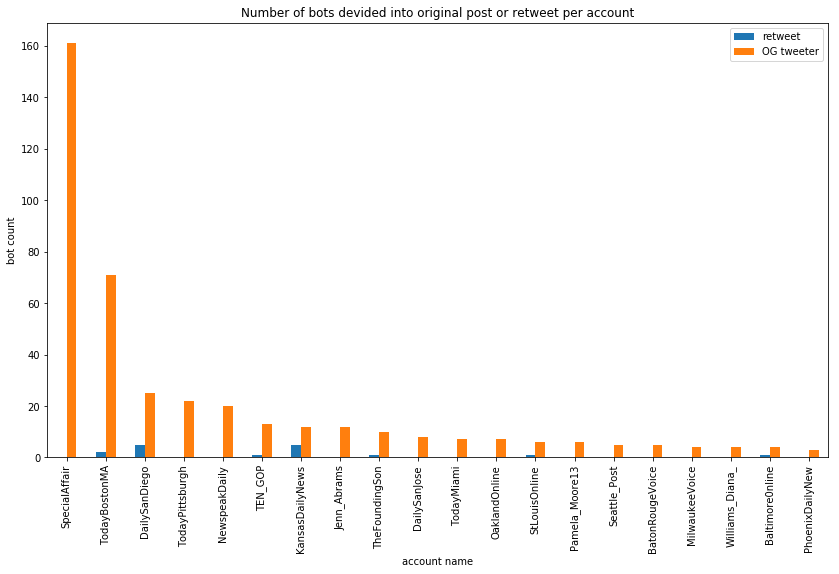

In [143]:
## number of tweets or retweets per bot account
# if sort_values(1.0,ascending = False) is replaced with sort_values(0.0,ascending = False) values are sorted by retweets
ax = only_bots.groupby(['OG', 'screen_name'])['screen_name'].count().unstack(0).sort_values(1.0,ascending = False)[:20].plot.bar(title="Number of bots devided into original post or retweet per account", figsize=(14,8))
_ = ax.set_xlabel('account name')
_ = ax.set_ylabel('bot count')
mylabels = ['retweet', 'OG tweeter']
_ = ax.legend(labels=mylabels)
plt.show()

In [165]:
# add a counter for the number of accounts with the tweet that are bot accounts. 
# wuth that i can see how much of the traffic of a bot was generated by another bot
bot_count = pd.DataFrame(only_bots.groupby('text').size().reset_index(name='bot_count'))
only_bots = only_bots.merge(bot_count, 'left', on = 'text')
only_bots['bot_traffic'] = only_bots['bot_count'] / only_bots['counts']

### mean percentage of bot traffic due to bots

In [169]:
print('mean percentage of bot traffic due to bots, ergo how many of the bots retweets are due to bots', 
     round(np.mean(only_bots['bot_traffic']), 2))
print('mean percentage of bot traffic when bot original post due to bots, ergo how many of the bots retweets are due to bots', 
     round(np.mean(only_bots['bot_traffic'][only_bots['OG'] == 1]), 2))

mean percentage of bot traffic due to bots, ergo how many of the bots retweets are due to bots 0.6
mean percentage of bot traffic when bot original post due to bots, ergo how many of the bots retweets are due to bots 0.78


# US

In [248]:
US_fake_news = pd.read_csv('US_one_month.csv')
US_fake_news['screen_name_low'] = US_fake_news['user_screen_name'].str.lower() # make name in OG date lowerstring 

In [250]:
screen_names_US = set(list(US_fake_news['screen_name_low']))
# create list of all bots account in brexit data
# it is all lower case. remember when merging
bot_acc_US = []
for i in screen_names_US:
    if i in russia_acc_low:
        bot_acc_US.append(i) # list of bots in data set

bot_acc_US

['ten_gop', 'crystal1johnson', 'pamela_moore13', 'southlonestar']

In [ ]:
bot_df_US = pd.DataFrame(bot_acc_US)
bot_df_US['bot'] = 1
bot_df_US.columns = ['screen_name_low', 'bot']
US_bots = US_fake_news.merge(bot_df_US, "left", on = 'screen_name_low')

# Mexico

In [212]:
mexico = pd.read_csv('Mexico_tweets.csv')
mexico['screen_name_low'] = mexico['screen_name'].str.lower() # make name in OG date lowerstring 
mexico['screen_name_low'] = mexico['screen_name_low'].replace('@', '', regex=True) # remove @ sign at beginning 

In [247]:
screen_names_mexico = set(list(mexico['screen_name_low']))
# create list of all bots account in brexit data
# it is all lower case. remember when merging
bot_acc_mexico = []
for i in screen_names_mexico:
    if i in russia_acc_low:
        bot_acc_mexico.append(i) # list of bots in data set
bot_acc_mexico


[]